In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [406]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import google.datalab.bigquery as bq
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Dense, Activation, Dropout
from tensorflow.contrib.keras.python.keras.preprocessing import text, sequence
from tensorflow.contrib.keras.python.keras import utils

from collections import Counter

# This code was tested with TensorFlow v1.3
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.3.0


In [ ]:
#load direct from BQ
query="""
SELECT tags 
FROM `bigquery-public-data.stackoverflow.posts_questions`
LIMIT 1000
"""

df = bq.Query(query).execute().result().to_dataframe()
df.head()

In [412]:
# The CSV was generated from this query: https://bigquery.cloud.google.com/savedquery/513927984416:c494494324be4a80b1fc55f613abb39c
# The data is also publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

data = pd.read_csv("data/1million000000000000.csv")
NUM_ROWS = data.shape[0]
print("Loaded {} rows".format(NUM_ROWS))

Loaded 101187 rows


In [413]:
#Preview Data
data.head()

,tags,post
0,c#,custom setter but auto getter i have an objec...
1,c#,how would you create a unique random number th...
2,c#,excluding .exe file (referenced by my app) sa...
3,c#,in what way does the newly created object of a...
4,c#,drag and drop functionality in list box in c# ...


In [414]:
data = data.sample(frac=1) #shuffle data
data.head()

,tags,post
99168,android|android-widget|android-imageview|andro...,display widget imageview based on month i hav...
3290,c#|xml,c# serialise model to objectcontent i have th...
8933,php|mysql,question of update data in php <pre><code>$que...
36770,android|android-view,exploring the view tree in android it s maybe...
62476,php|symfony|twig|symfony-2.1,symfony2 session-flash with if clause in twig ...


In [446]:
#Generate list of N most common labels
NUM_CLASSES = 2
labels_list = []

counts = Counter('|'.join(data['tags'].tolist()).split('|'))
classes = counts.most_common(NUM_CLASSES)

for i in range(0,NUM_CLASSES):
    labels_list.append(classes[i][0])
    
print ("{} most common classes:".format(NUM_CLASSES))
classes

2 most common classes:


[('javascript', 21079), ('java', 18853)]

In [447]:
#utility functions to extract classes and translate between 
#human friendly (string) labels and machine friendly (array) labels

#labels_list: A list of the valid classes
#tags: A list of tags for a post
#returns an ndarray with ones for the active classes
def labels_to_array(tags,labels_list=labels_list):
    array = np.zeros(len(labels_list),dtype=np.int8)
    tags = tags.split('|') #split tags from pipe separated string into list
    for tag in tags:
        try:
            array[labels_list.index(tag)] = 1
        except ValueError: 
            None
    return array

#translate machine readable array back to human labels
def array_to_labels(array, labels_list=labels_list, threshold = 1):
    labels = []
    i=0
    for flag in array:
        if flag >= threshold: 
            labels.append(labels_list[i])
        i=i+1
    return labels

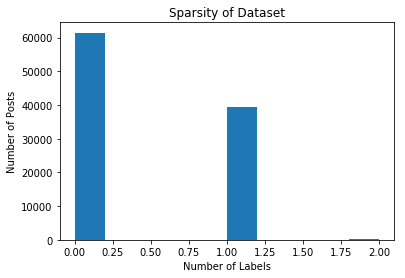

In [448]:
#Find label density
label_counts = np.zeros(NUM_ROWS)
for i in range(len(label_counts)):
    label_counts[i] = labels_to_array(data['tags'][i]).sum()
    
plt.xlabel('Number of Labels')
plt.ylabel('Number of Posts')
plt.title('Sparsity of Dataset')
plt.hist(label_counts)
plt.show()

In [449]:
#test utility functions
print(data['tags'][4])
array = labels_to_array(data['tags'][4])
print(array)
array_to_labels(array)

c#
[0 0]


[]

In [450]:
# Split data into train and test
train_size = int(len(data) * .8)
test_size = len(data)-train_size
print ("Train size: %d" % train_size)
print ("Test size: %d" % test_size)

Train size: 80949
Test size: 20238


In [451]:
train_posts = data['post'][:train_size]
train_tags = data['tags'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['tags'][train_size:]

In [452]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [453]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [454]:
# generate multi-label arrays
y_train = np.zeros([train_size,NUM_CLASSES])
for i in range(0,train_size):
    y_train[i] = labels_to_array(data['tags'][i])

y_test = np.zeros([test_size,NUM_CLASSES])
for i in range(0,test_size):
    y_test[i] = labels_to_array(data['tags'][i+train_size-1])
y_test[0]

array([ 0.,  0.])

In [455]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (80949, 1000)
x_test shape: (20238, 1000)
y_train shape: (80949, 2)
y_test shape: (20238, 2)


In [457]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 100
epochs = 1

In [458]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('sigmoid')) #changed from softmax

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) #changed from categorical_crossentropy

In [461]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 72854 samples, validate on 8095 samples
Epoch 1/1
72854/72854 [==============================] - 7s - loss: 0.4803 - acc: 0.8138 - val_loss: 0.5633 - val_acc: 0.7642


In [462]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

19800/20238 [============================>.] - ETA: 0sTest score: 0.544197173599
Test accuracy: 0.77789307414


In [464]:
# Here's how to generate a prediction on individual examples
for i in range(100):
    prediction = model.predict(np.array([x_test[i]]))
    print(prediction[0])
    print(y_test[i])
    predicted_label = array_to_labels(prediction[0],threshold=.5)
    print(test_posts.iloc[i][:200], "...")
    print('Actual label:' + '|'.join(array_to_labels(y_test[i])))
    print("Predicted label: " + '|'.join(predicted_label) + '\n')  

[ 0.11088554  0.12836155]
[ 0.  0.]
error when click on the listview android  im still new in android development.. i face a problem to develop searching function on my apps.. im using the code from this website  <a href= http://www.mys ...
Actual label:
Predicted label: 

[ 0.15573704  0.1757793 ]
[ 0.  0.]
how to open a file in memory   i have see this term branded around but i don t really understand how you open a file in memory.    i have the files written to disk in a temp location but this needs cl ...
Actual label:
Predicted label: 

[ 0.1917156   0.21255441]
[ 0.  0.]
timestamp php to jquery format  im looking for the function in jquery  that giveme the same format of time  like this.   <pre><code>date(  y-m-d\th:i:sp ); //the output is like this. 2013-10-30t18:10: ...
Actual label:
Predicted label: 

[ 0.19112061  0.21598065]
[ 0.  0.]
c# button with multiple events  i am trying to overwrite a content in an label several times by always clicking the same button. unfortunately

In [20]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=labels_list, title="Confusion matrix")
plt.show()

NameError: name 'y_test_1d' is not defined

In [ ]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [ ]:
#cross entropy function

def cross_entropy(y_target,y_pred):
    loss_sum = 0
    for i in range(len(y_target)):
        if y_target[i]==1: loss_sum += -np.log(y_pred[i])
        else: loss_sum += -np.log(1-y_pred[i])
    return loss_sum/len(y_target)